In [1]:
get_ipython().magic('matplotlib notebook')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
import os 
import numpy as np
import time
import matplotlib
matplotlib.rcParams['contour.negative_linestyle']= 'solid'
import matplotlib.pyplot as plt
import matplotlib.patches as Polygon
import copy as cp
import cmocean
import glob 
import xarray

#+____IMPORT FESOM RELATET ROUTINES____________________________________________+
from set_inputarray  import *
from sub_fesom_mesh  import * 
from sub_fesom_data  import * 
from sub_fesom_moc   import *
from colormap_c2c    import *

In [2]:
#+_____________________________________________________________________________+
#|                                                                             |
#|                         *** LOAD FVSOM MESH ***                             |
#|                                                                             |
#+_____________________________________________________________________________+
# for more options look in set_inputarray.py
inputarray=set_inputarray()
inputarray['save_fig'],inputarray['save_figpath'] = True, '/p/project/chhb19/streffing1/postprocessing/2020_AWICM3_GMD_PAPER/python/'
inputarray['mesh_id'],inputarray['mesh_dir'] = 'COREv2', '/p/project/chhb19/streffing1/input/fesom2/core2/'
inputarray['mesh_rotate' ]==False
try:
	mesh
except NameError:
	mesh = fesom_init_mesh(inputarray)
else:
    #if mesh.id!=inputarray['mesh_id']:
    mesh = fesom_init_mesh(inputarray)
    #else:
    #    print(' --> ___FOUND {} FESOM MESH --> will use it!___________________________'.format(mesh.id))   


___LOAD FESOM MESH COREv2_________________________________________
 --> read grid files
     > nod2d.out  : #2dn=126858
     > elem2d.out : #2de=244659
     > aux3d.out
     > nlvls.out
     > elvls.out
 --> remove cyclic boundary
_______________________________________________________________


# Calculate Meridional Overturning Circulation (MOC) Profile

Use for the calculation of the Meridional Overturning Circulation (MOC) the equation for the calculation of the "Pseudostreamfunction". Condition for the calculation of the regional MOC (i.e AMOC, PMOC, IMOC) is that the domain over which the caluclation is carried out, is approximately sorounded by a coast (Bering Strait can be accouted as coast its just 30m deep). Since Atlantic, Pacific and Indian Ocean have no southern coastal boundary the AMOC and PMOC can just be calculated until -30°S and the meridional cumulativ integration has to be carried out from North to South instead South to North which leads to an additional minus sign in the calcualtion (see: sub_fesom_moc.py, line:137)
$${\int_E^W w(x',y,z) dx' = {{\partial\Psi} \over {\partial y}}}$$
$$ \textrm{GMOC:} ~~~  {\Psi(y,z) = \int_S^N {\int_E^W w(x',y',z) \cdot dx'} dy'} ~~$$
$$ \textrm{AMOC:} ~~~  {\Psi(y,z) = -\int_N^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$
$$ \textrm{PMOC:} ~~~  {\Psi(y,z) = -\int_{Bering Strait} ^{-30S^\circ} {\int_E^W w(x',y',z) \cdot dx'} dy'} $$

_____calc. AMOC from vertical velocities via meridional bins_____
 --> calculate basin limited domain >> use rtracing parallel 

/p/project/chhb19/jstreffi/software/miniconda3/envs/pyfesom2/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


 >> time: 1.423 s
 --> calc. triangle area m^2 >> time:0.023 s
 --> total time:1.832 s


<IPython.core.display.Javascript object>


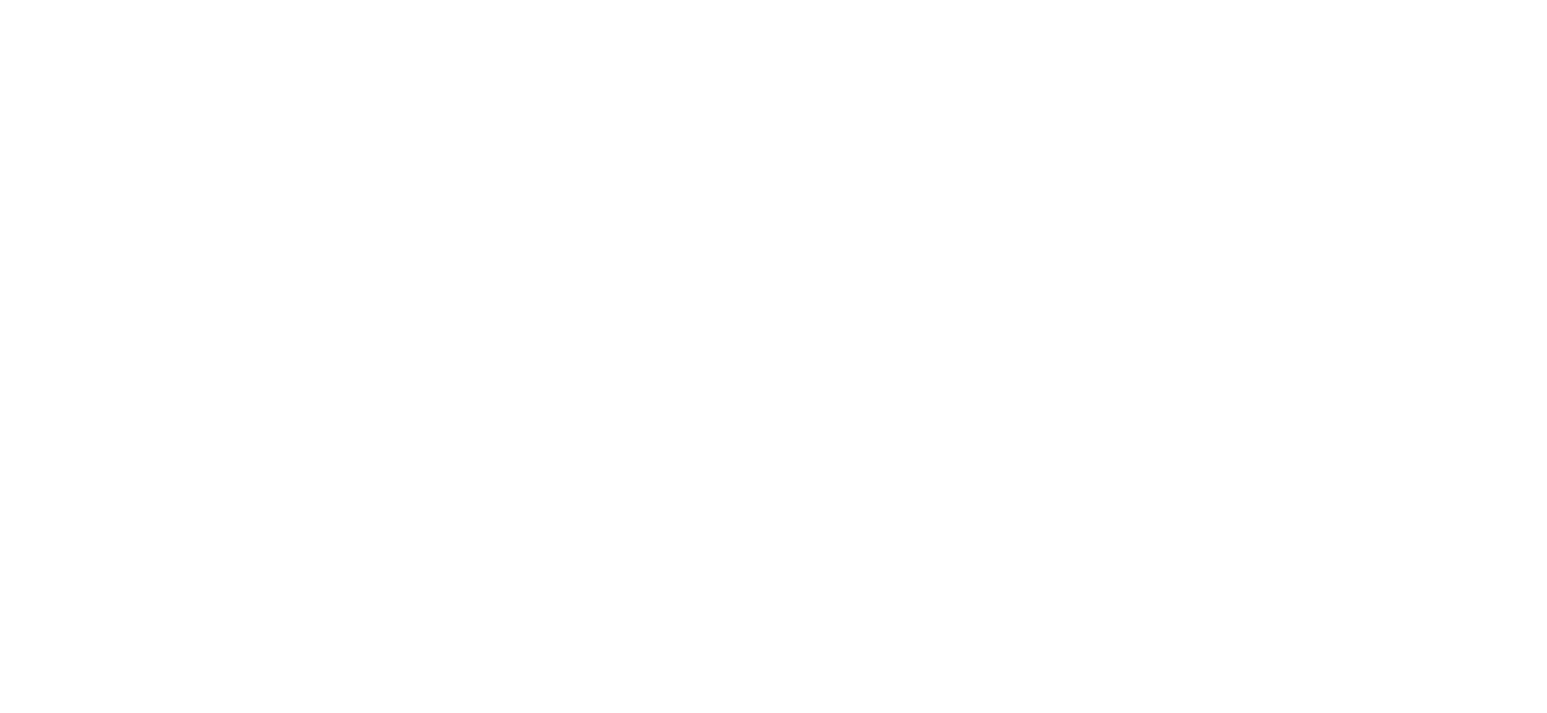

-4.341003937064307 20.179166131864974 0.0
[(0.0, [0.17647058823529413, 0.0, 0.29411764705882354]), (0.1, [0.601922337562476, 0.5629373317954633, 0.750480584390619]), (0.2, [0.9691657054978854, 0.9668589004229142, 0.9636293733179546]), (0.6, [0.9319492502883506, 0.6094579008073817, 0.22422145328719714]), (1.0, [0.4980392156862745, 0.23137254901960785, 0.03137254901960784])]
[(0.0, [0.17647058823529413, 0.0, 0.29411764705882354]), (0.1, [0.601922337562476, 0.5629373317954633, 0.750480584390619]), (0.2, [0.9691657054978854, 0.9668589004229142, 0.9636293733179546]), (0.6, [0.9319492502883506, 0.6094579008073817, 0.22422145328719714]), (1.0, [0.4980392156862745, 0.23137254901960785, 0.03137254901960784])] PuOr_r [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20.]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20.]


/p/project/chhb19/jstreffi/postprocessing/2020_AWICM3_GMD_PAPER/python/sub_fesom_moc.py:269: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(hp1,ax=ax1,ticks=clevel,drawedges=True,extend='neither',extendrect=False,extendfrac='auto')


 --> save figure: png


/tmp/ipykernel_28150/3451556819.py:47: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)


In [3]:
#%%prun -s cumulative -q -l 100 -D profile.bin
#____________________________________________________________________________________________________
# load vertical velocity data
data1 		 	= fesom_data(inputarray) 
data1.var 		= 'w'
data1.descript,data1.path = 'PICT 1990 to 2014' ,'/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/fesom'
data1.year, data1.month= [2505,2529], [1,2,3,4,5,6,7,8,9,10,11,12]
data1.cmap,data1.cnumb = 'red2blue', 10
add_bolusw = False
#____________________________________________________________________________________________________
# load vertical velocity datas for big meshes using xarray
fesom_load_data3d_4bm(mesh,data1,do_output=False)

#____________________________________________________________________________________________________
# add GM bolus velocity
if add_bolusw:
    data_bw     = cp.deepcopy(data1)
    data_bw.var ='bolus_w'
    fesom_load_data_horiz(mesh,data_bw,do_output=False)
    data1.value = data1.value+data_bw.value
    del data_bw

#%%prun -s cumulative -q -l 100 -D profile.bin #write out profile file usable with snakeviz profile.bin
#____________________________________________________________________________________________________
# select XMOC
which_moc = 'amoc'

#____________________________________________________________________________________________________
# calc XMOC
moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=which_moc,out_elemidx=True)
#moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc,in_elemidx=elemidx)

# moc1,lat,bottom,elemidx  = calc_xmoc(mesh,data1,which_moc=amoc,out_elemidx=True)
# --> writes out elem index to use for AMOC or PMOC can be directly read into next calucation of amoc 
# --> moc2,lat,bottom      =calc_xmoc(mesh,data2,which_moc=amoc,in_elemidx=elemidx)
#____________________________________________________________________________________________________
# plot XMOC
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time,crange=[],cnumb=15)

#____________________________________________________________________________________________________
# save XMOC
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    
#____________________________________________________________________________________________________    
# which_moc = 'amoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
# which_moc = 'pmoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
# which_moc = 'imoc'
# moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)

<IPython.core.display.Javascript object>


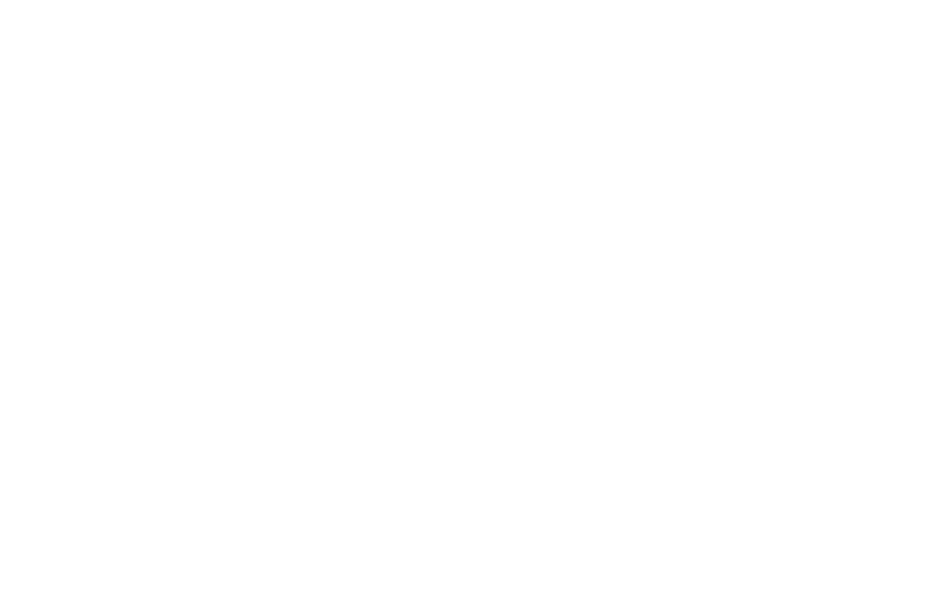

-4.341003937064307 19.99999988079071 0.0
[(0.0, [0.17647058823529413, 0.0, 0.29411764705882354]), (0.1, [0.601922337562476, 0.5629373317954633, 0.750480584390619]), (0.2, [0.9691657054978854, 0.9668589004229142, 0.9636293733179546]), (0.6, [0.9319492502883506, 0.6094579008073817, 0.22422145328719714]), (1.0, [0.4980392156862745, 0.23137254901960785, 0.03137254901960784])]
[(0.0, [0.17647058823529413, 0.0, 0.29411764705882354]), (0.1, [0.601922337562476, 0.5629373317954633, 0.750480584390619]), (0.2, [0.9691657054978854, 0.9668589004229142, 0.9636293733179546]), (0.6, [0.9319492502883506, 0.6094579008073817, 0.22422145328719714]), (1.0, [0.4980392156862745, 0.23137254901960785, 0.03137254901960784])] PuOr_r [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20.]
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20.]


/p/project/chhb19/jstreffi/postprocessing/2020_AWICM3_GMD_PAPER/python/sub_fesom_moc.py:269: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(hp1,ax=ax1,ticks=clevel,drawedges=True,extend='neither',extendrect=False,extendfrac='auto')


 --> save figure: png


/tmp/ipykernel_28150/1584755377.py:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)


In [4]:
# plot XMOC
data1.cmap,data1.cnumb = 'PuOr', 10

# fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time)
fig,ax=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time,crange=[],cnumb=15,figsize=[8,5])
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    

## --> Calculate anomaly of MOC

In [ ]:
which_moc = 'amoc'
#____________________________________________________________________________________________________
# load vertical velocity data
data1 = fesom_data(inputarray) 
data1.var = 'w'
data1.descript,data1.path = 'HIST 1990 to 2014' ,'/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom'
data1.year, data1.month= [1990,2014], [1,2,3,4,5,6,7,8,9,10,11,12]
fesom_load_data3d_4bm(mesh,data1,do_output=False)

data2 = cp.deepcopy(data1)
data2.descript,data2.path = 'SPIN last 25 years' ,'/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/fesom'
data2.year, data2.month= [2524,2549], [1,2,3,4,5,6,7,8,9,10,11,12]
fesom_load_data3d_4bm(mesh,data2,do_output=False)

anom  = fesom_data_anom(data2,data1)

#____________________________________________________________________________________________________
# calc XMOC anomaly
moc1,lat,bottom  = calc_xmoc(mesh,data1,which_moc=which_moc)
moc2,lat,bottom  = calc_xmoc(mesh,data2,which_moc=which_moc)
# moca,lat,bottom  = calc_xmoc(mesh,anom,which_moc=which_moc)
moca = moc1-moc2

#____________________________________________________________________________________________________
# plot XMOC anomaly
cmin   = np.min([moc1[np.where(mesh.zlev<=-500)[0][0]::,:].min(),moc2[np.where(mesh.zlev<=-500)[0][0]::,:].min()])
cmax   = np.max([moc1[np.where(mesh.zlev<=-500)[0][0]::,:].max(),moc2[np.where(mesh.zlev<=-500)[0][0]::,:].max()])
crange = [cmin,cmax,0.0]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[18,9])
fig,ax1=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,do_subplot=[fig,ax1],which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time,crange=crange)
fig,ax2=plot_xmoc(lat,mesh.zlev,moc2,bottom=bottom,do_subplot=[fig,ax2],which_moc=which_moc,str_descript=data2.descript,str_time=data2.str_time,crange=crange)
fig,ax3=plot_xmoc(lat,mesh.zlev,moca,bottom=bottom,do_subplot=[fig,ax3],which_moc=which_moc,str_descript=anom.descript ,str_time=anom.str_time)

<IPython.core.display.Javascript object>


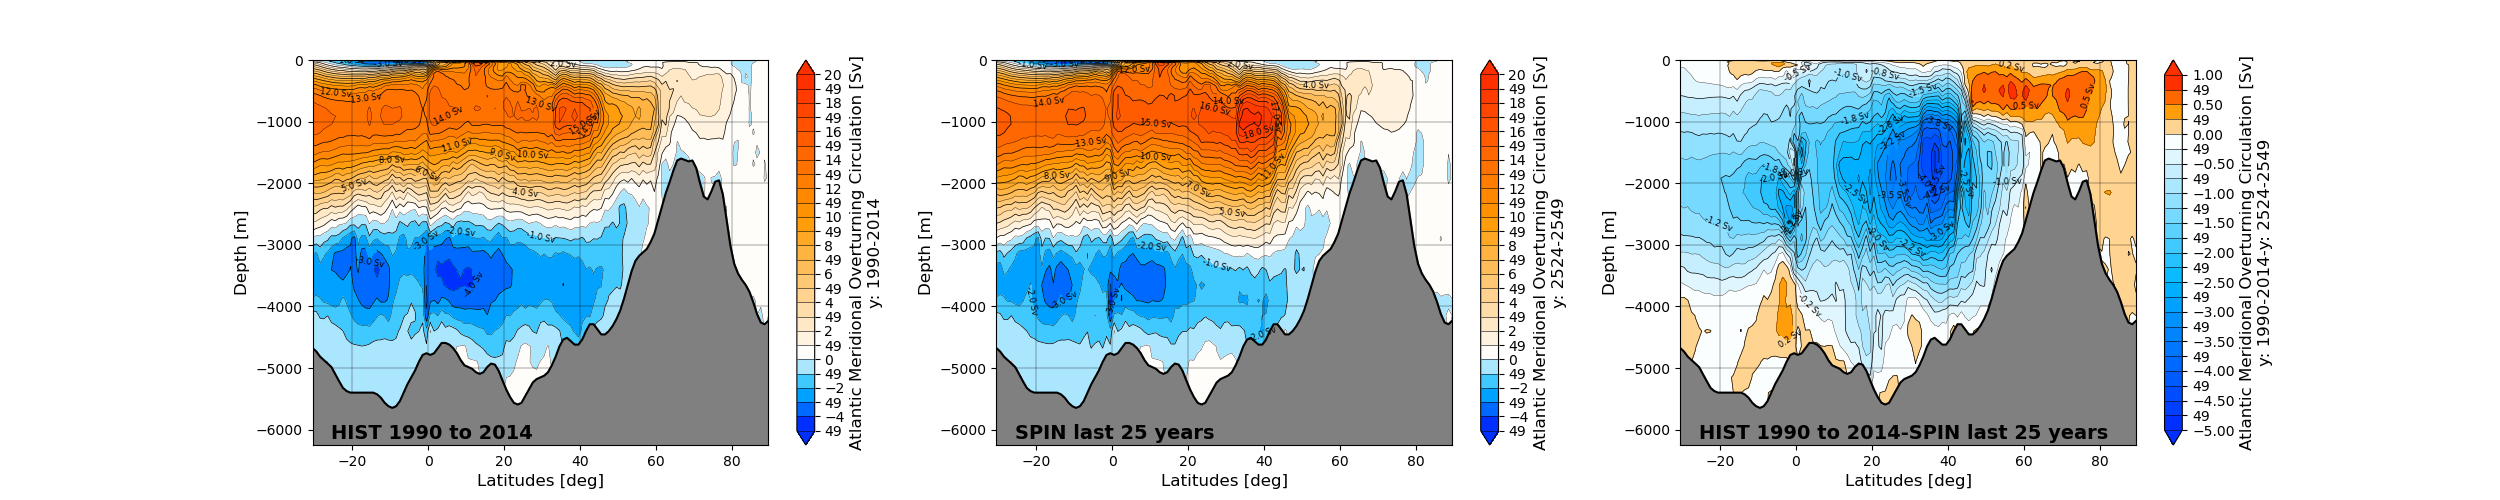

-4.359335320653715 19.87538187120378 0.0


/p/home/jusers/streffing1/juwels/view_pscholz/sub_fesom_moc.py:250: UserWarning: The following kwargs were not used by contour: 'antialised'
  CS=plt.contour(lat,depth,data_plot,levels=clevel,colors='k',linewidths=[0.5,0.25],antialised=True)
/p/home/jusers/streffing1/juwels/view_pscholz/sub_fesom_moc.py:268: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(hp1,ax=ax1,ticks=clevel,drawedges=True,extend='neither',extendrect=False,extendfrac='auto')


-4.359335320653715 19.87538187120378 0.0


/p/home/jusers/streffing1/juwels/view_pscholz/sub_fesom_moc.py:250: UserWarning: The following kwargs were not used by contour: 'antialised'
  CS=plt.contour(lat,depth,data_plot,levels=clevel,colors='k',linewidths=[0.5,0.25],antialised=True)
/p/home/jusers/streffing1/juwels/view_pscholz/sub_fesom_moc.py:268: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(hp1,ax=ax1,ticks=clevel,drawedges=True,extend='neither',extendrect=False,extendfrac='auto')


-4.813588532353403 0.8257091587257896 0.0


/p/home/jusers/streffing1/juwels/view_pscholz/sub_fesom_moc.py:250: UserWarning: The following kwargs were not used by contour: 'antialised'
  CS=plt.contour(lat,depth,data_plot,levels=clevel,colors='k',linewidths=[0.5,0.25],antialised=True)
/p/home/jusers/streffing1/juwels/view_pscholz/sub_fesom_moc.py:268: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar1 = plt.colorbar(hp1,ax=ax1,ticks=clevel,drawedges=True,extend='neither',extendrect=False,extendfrac='auto')


In [17]:
# plot XMOC anomaly
cmin   = np.min([moc1[np.where(mesh.zlev<=-500)[0][0]::,:].min(),moc2[np.where(mesh.zlev<=-500)[0][0]::,:].min()])
cmax   = np.max([moc1[np.where(mesh.zlev<=-500)[0][0]::,:].max(),moc2[np.where(mesh.zlev<=-500)[0][0]::,:].max()])
crange = [cmin,cmax,0.0]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[25,5])
fig,ax1=plot_xmoc(lat,mesh.zlev,moc1,bottom=bottom,do_subplot=[fig,ax1],which_moc=which_moc,str_descript=data1.descript,str_time=data1.str_time,crange=crange)
fig,ax2=plot_xmoc(lat,mesh.zlev,moc2,bottom=bottom,do_subplot=[fig,ax2],which_moc=which_moc,str_descript=data2.descript,str_time=data2.str_time,crange=crange)
fig,ax3=plot_xmoc(lat,mesh.zlev,moca,bottom=bottom,do_subplot=[fig,ax3],which_moc=which_moc,str_descript=anom.descript ,str_time=anom.str_time)

## --> Calculate MOC Time-Series

 --> CALC YEAR:
|1850 >> use rtracing parallel  >> time: 1.164 s
|1851|1852|1853|1854|1855|1856|1857|1858|1859|1860|1861|1862|1863|1864|
|1865|1866|1867|1868|1869|1870|1871|1872|1873|1874|1875|1876|1877|1878|1879|
|1880|1881|1882|1883|1884|1885|1886|1887|1888|1889|1890|1891|1892|1893|1894|
|1895|1896|1897|1898|1899|1900|1901|1902|1903|1904|1905|1906|1907|1908|1909|
|1910|1911|1912|1913|1914|1915|1916|1917|1918|1919|1920|1921|1922|1923|1924|
|1925|1926|1927|1928|1929|1930|1931|1932|1933|1934|1935|1936|1937|1938|1939|
|1940|1941|1942|1943|1944|1945|1946|1947|1948|1949|1950|1951|1952|1953|1954|
|1955|1956|1957|1958|1959|1960|1961|1962|1963|1964|1965|1966|1967|1968|1969|
|1970|1971|1972|1973|1974|1975|1976|1977|1978|1979|1980|1981|1982|1983|1984|
|1985|1986|1987|1988|1989|1990|1991|1992|1993|1994|1995|1996|1997|1998|1999|
|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|


<IPython.core.display.Javascript object>


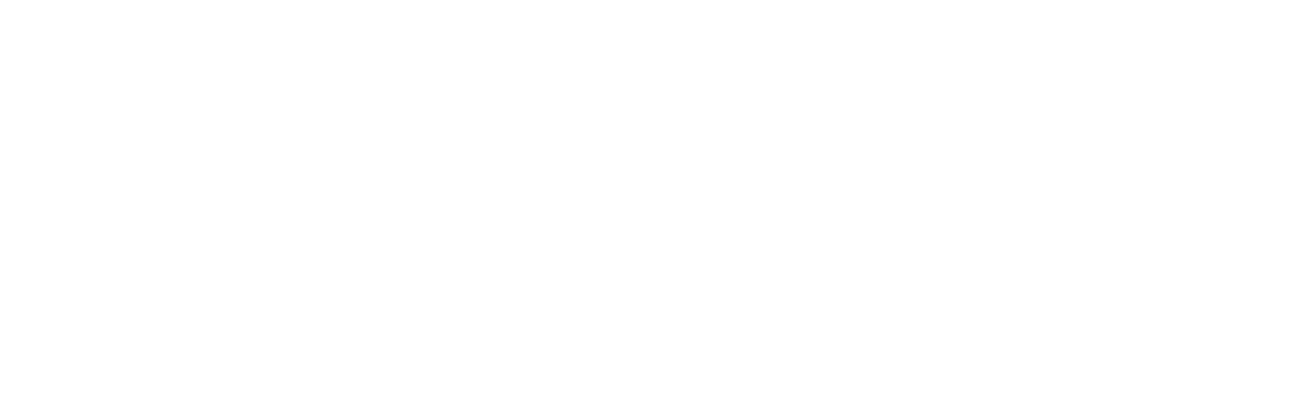

 --> save figure: png


/tmp/ipykernel_5735/2381792664.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)


In [16]:
which_moc='amoc'
which_lat=[26.0, 40.0,'max']
#____________________________________________________________________________________________________
# load vertical velocity data
data1 	   = fesom_data(inputarray) 
data1.var = 'w'
data1.descript,data1.path = 'HIST' ,'/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/HIST/outdata/fesom'
data1.year, data1.month= [1850,2014], [1,2,3,4,5,6,7,8,9,10,11,12]

#____________________________________________________________________________________________________
# be sure mesh has the right focus 
if which_moc=='amoc2' or which_moc=='amoc':
    # for calculation of amoc mesh focus must be on 0 degree longitude
    if mesh.focus!=0:
       mesh.focus=0
       mesh.fesom_grid_rot_r2g(str_mode='focus')
elif which_moc=='pmoc':
     if mesh.focus!=180:
        mesh.focus=180
        mesh.fesom_grid_rot_r2g(str_mode='focus')
#____________________________________________________________________________________________________
# calc MOC time-series
count=0
print(' --> CALC YEAR:')
datayr = cp.deepcopy(data1)
moc_t = np.zeros((data1.year[1]-data1.year[0]+1,len(which_lat)))
time  = np.zeros((data1.year[1]-data1.year[0]+1,))
for year in range(data1.year[0],data1.year[1]+1):
    #_______________________________________________________________________________________________
    print('|'+str(year),end='')
    if np.mod(count+1,15)==0: print('|')
        
    #_______________________________________________________________________________________________
    # load vertical velocity data --> calculates yearly means
    datayr.year		= [year,year]
    # fesom_load_data_horiz(mesh,datayr,do_output=False)
    fesom_load_data3d_4bm(mesh,datayr,do_output=False) 
    
    #_______________________________________________________________________________________________
    # calculate AMOC vor every year
    if count==0:
        moc_prof,lat,bottom,elemidx  = calc_xmoc(mesh,datayr,which_moc=which_moc,out_elemidx=True,do_output=False)
    else:
        moc_prof,lat,bottom          = calc_xmoc(mesh,datayr,which_moc=which_moc,in_elemidx=elemidx,do_output=False)
    #_______________________________________________________________________________________________
    # look for maximum value below 500m at certain latitude or between latitudinal range 'max' 
    # (looks between 30°N and 45°N)
    moc_d=moc_prof[np.where(mesh.zlev<=-500)[0],:]
    count_lat=0
    for lati in which_lat:
        if lati=='max':
            moc_l= moc_d[:,np.where((lat>=30) & (lat<=45))[0]]
        else:
            moc_l= moc_d[:,np.where(lat>=lati)[0][0]]
        moc_t[count,count_lat]=moc_l.max()
        count_lat=count_lat+1
    time[count]=year    
    count=count+1
    
#____________________________________________________________________________________________________
# plot MOC time-series
fig,ax=plot_xmoc_tseries(time,moc_t,which_lat,which_moc)    
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    
#___________________

<IPython.core.display.Javascript object>


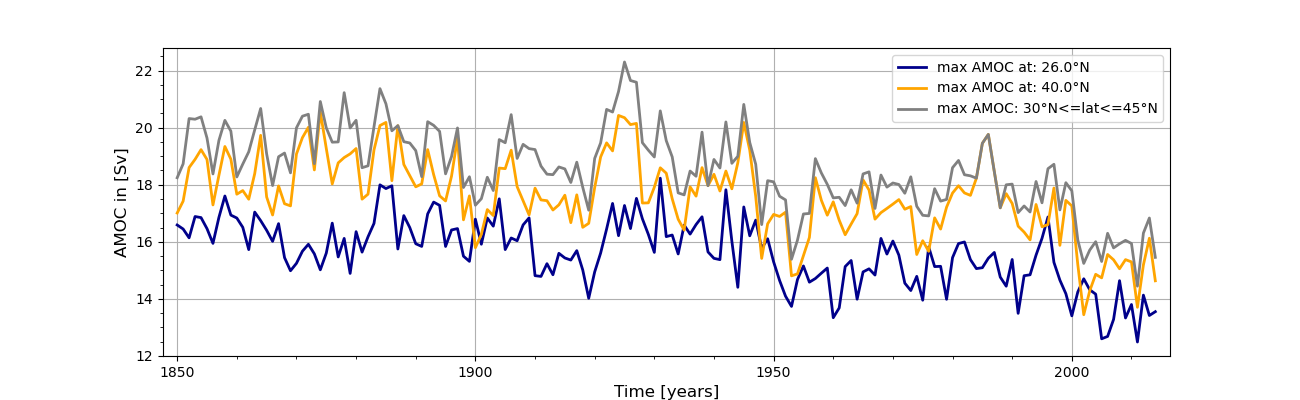

 --> save figure: png


/tmp/ipykernel_5735/332836251.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)


In [19]:
# plot MOC time-series
fig,ax=plot_xmoc_tseries(time,moc_t,which_lat,which_moc)    
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    

<IPython.core.display.Javascript object>


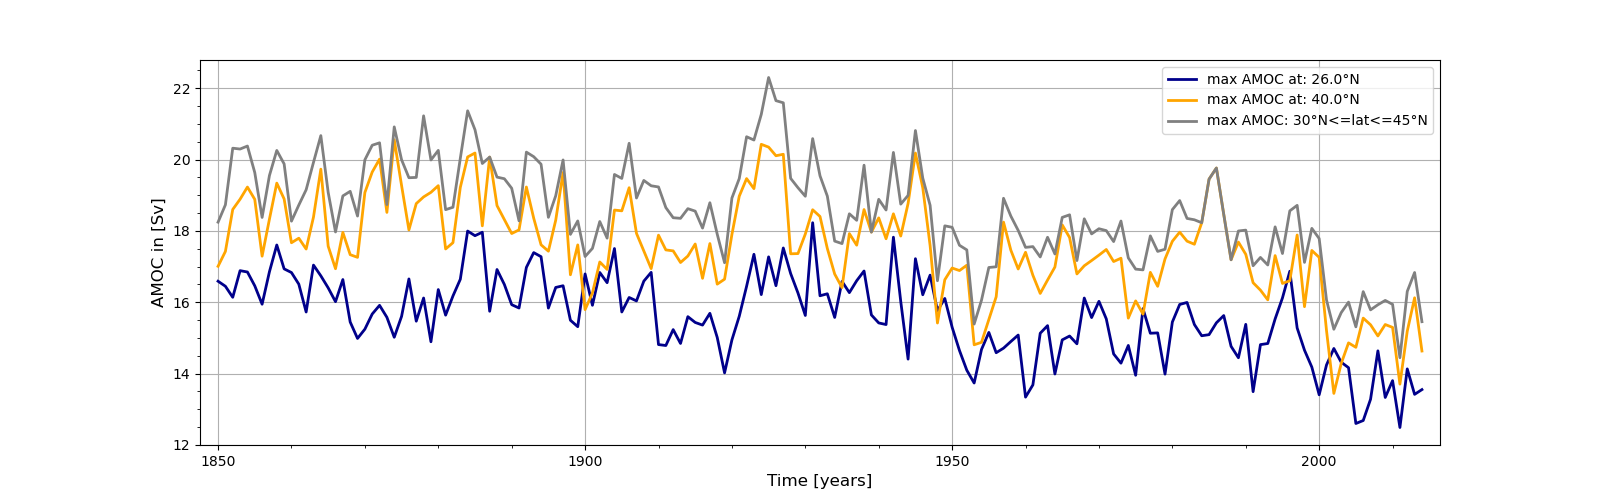

 --> save figure: png


/tmp/ipykernel_5735/3053477772.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)


In [20]:
# plot MOC time-series
fig,ax=plot_xmoc_tseries(time,moc_t,which_lat,which_moc,figsize=(16,5))    
if inputarray['save_fig']==True:
    print(' --> save figure: png')
    str_times= data1.str_time.replace(' ','').replace(':','') 
    sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_'+str_times+'.png'
    plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
    
#___________________

In [11]:
sdname, sfname = inputarray['save_figpath'], 'plot_'+data1.descript+'_'+which_moc+'_timeseries.png'
plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)


/tmp/ipykernel_20888/3454833343.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(sdname+sfname, format='png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True, frameon=True)
